In [13]:
# Libraries and data setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import LinearSegmentedColormap

colors = {
    'precision': '#59A14F',
    'recall':    '#F28E2B',
    'f1_score':  '#4E79A7'
}

df_manual = pd.read_parquet(
    '../data/manual_predictions.parquet',
    columns=['id','rating']
    ).rename(
        columns={'rating':'rating_manual'}
    )
df_llm = pd.read_parquet(
    '../data/llm_predictions.parquet',
    columns=['id','model','rating','processing_time']
    ).rename(
        columns={'rating':'rating_llm'}
    )
df_comments = pd.read_parquet(
    '../data/comments_sample.parquet',
    columns=['id','rating','comment_length_group','language']
    ).rename(
        columns={'rating':'rating_real'}
    )

print(f"Comments manually predicted: {len(df_manual)}")
print(f"LLM predictions: {len(df_llm)}")
print(f"LLM models: {set(df_llm['model'])}")
print('\n')

df = (
    df_manual
    .merge(df_llm, on='id', how='left')
    .merge(df_comments, on='id', how='inner')
    )

for type in ['manual','llm']:
    df[f'is_inconsistent_{type}'] = (
        (df[f'rating_{type}'] - df['rating_real']).abs() > 1
        ).astype(int)

df.info()

Comments manually predicted: 429
LLM predictions: 18000
LLM models: {'qwen2.5:1.5b', 'qwen2.5:3b', 'llama3.1:8b', 'gemma3:4b', 'qwen3:8b', 'qwen2.5:0.5b', 'qwen3:4b', 'gemma3:12b', 'stablelm2:12b', 'phi3:3.8b', 'qwen3:1.7b', 'gemma3:1b', 'stablelm2:1.6b', 'deepseek-r1:8b', 'llama3.2:3b', 'llama2:7b', 'qwen3:0.6b', 'deepseek-r1:1.5b'}


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      7200 non-null   object 
 1   rating_manual           7200 non-null   int64  
 2   model                   7200 non-null   object 
 3   rating_llm              7200 non-null   float64
 4   processing_time         7200 non-null   float64
 5   rating_real             7200 non-null   int64  
 6   comment_length_group    7200 non-null   int64  
 7   language                7200 non-null   object 
 8   is_inconsistent_manu

In [14]:
# model_metrics_df
y_true = df['is_inconsistent_manual']
y_pred = df['is_inconsistent_llm']

df = df.dropna(subset=['model'])

metrics = []
for model, group in df.groupby('model'):
    y_true = group['is_inconsistent_manual']
    y_pred = group['is_inconsistent_llm']

    metrics.append({
        'model': model,
        'accuracy':  accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall':    recall_score(y_true, y_pred, zero_division=0),
        'f1_score':  f1_score(y_true, y_pred, zero_division=0)
    })

model_metrics_df = pd.DataFrame(metrics).sort_values('f1_score', ascending=False)

model_metrics_df['parameters'] = (
    model_metrics_df['model']
      .str.extract(r':([\d\.]+)b')[0]
      .astype(float)
)

mean_times = (
    df
    .groupby('model')['processing_time']
    .mean()
    .reset_index(name='avg_processing_time')
    .round(2)
)

model_metrics_df = model_metrics_df.merge(mean_times,on='model',how='left')

display(model_metrics_df.head())


,model,accuracy,precision,recall,f1_score,parameters,avg_processing_time
0,stablelm2:12b,0.8775,0.743243,0.647059,0.691824,12.0,7.14
1,qwen3:4b,0.8525,0.635417,0.717647,0.674033,4.0,2.24
2,llama2:7b,0.8350,0.585586,0.764706,0.663265,7.0,4.69
3,qwen2.5:0.5b,0.7450,0.452514,0.952941,0.613636,0.5,0.35
4,deepseek-r1:8b,0.8025,0.528846,0.647059,0.582011,8.0,3.69


In [15]:
# Model groups
small_3 = model_metrics_df.nsmallest(3, 'parameters')['model'].tolist()
small_5 = model_metrics_df.nsmallest(5, 'parameters')['model'].tolist()
big_3   = model_metrics_df.nlargest(3,  'parameters')['model'].tolist()
big_5   = model_metrics_df.nlargest(5,  'parameters')['model'].tolist()

fast_3 = model_metrics_df.nsmallest(3, 'avg_processing_time')['model'].tolist()
fast_5 = model_metrics_df.nsmallest(5, 'avg_processing_time')['model'].tolist()
slow_3 = model_metrics_df.nlargest(3,  'avg_processing_time')['model'].tolist()
slow_5 = model_metrics_df.nlargest(5,  'avg_processing_time')['model'].tolist()

groups = {
    'small_3': small_3,
    'small_5': small_5,
    'big_3':   big_3,
    'big_5':   big_5,
    'fast_3':  fast_3,
    'fast_5':  fast_5,
    'slow_3':  slow_3,
    'slow_5':  slow_5
}

for label, models in groups.items():
    print(f"{label:7}: {models}")

small_3: ['qwen2.5:0.5b', 'qwen3:0.6b', 'gemma3:1b']
small_5: ['qwen2.5:0.5b', 'qwen3:0.6b', 'gemma3:1b', 'deepseek-r1:1.5b', 'qwen2.5:1.5b']
big_3  : ['stablelm2:12b', 'gemma3:12b', 'deepseek-r1:8b']
big_5  : ['stablelm2:12b', 'gemma3:12b', 'deepseek-r1:8b', 'qwen3:8b', 'llama3.1:8b']
fast_3 : ['qwen2.5:0.5b', 'qwen3:0.6b', 'qwen2.5:1.5b']
fast_5 : ['qwen2.5:0.5b', 'qwen3:0.6b', 'qwen2.5:1.5b', 'gemma3:1b', 'deepseek-r1:1.5b']
slow_3 : ['stablelm2:12b', 'gemma3:12b', 'llama2:7b']
slow_5 : ['stablelm2:12b', 'gemma3:12b', 'llama2:7b', 'deepseek-r1:8b', 'qwen3:8b']


In [16]:
# group_metrics_df
param_df = pd.DataFrame({
    'model': [m for modelos in groups.values() for m in modelos],
    'parameters': [float(m.split(':')[1].replace('b',''))
                   for modelos in groups.values() for m in modelos]
})

time_df = (
    df
    .groupby('model')['processing_time']
    .mean()
    .reset_index(name='avg_processing_time')
    .round(2)
)

group_models = pd.DataFrame([
    {'group': f'{g}_majority', 'model': m}
    for g, modelos in groups.items()
    for m in modelos
])

group_stats = (
    group_models
    .merge(param_df, on='model')
    .merge(time_df, on='model')
    .groupby('group')
    .agg(parameters=('parameters','sum'),
         avg_processing_time=('avg_processing_time','sum'))
    .reset_index()
)

metrics = []
manual = df[['id','is_inconsistent_manual']].drop_duplicates('id').set_index('id')

for group_name, modelos in groups.items():
    sub = df[df['model'].isin(modelos)].drop_duplicates(['id','model'])
    wide = (
        sub
        .pivot(index='id', columns='model', values='is_inconsistent_llm')
        .fillna(0).astype(int)
    )
    threshold = len(modelos) / 2
    y_pred = (wide.sum(axis=1) > threshold).astype(int)
    y_true = manual.loc[y_pred.index, 'is_inconsistent_manual']
    metrics.append({
        'group':     f'{group_name}_majority',
        'accuracy':  accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall':    recall_score(y_true, y_pred, zero_division=0),
        'f1_score':  f1_score(y_true, y_pred, zero_division=0)
    })

group_metrics_df = (
    pd.DataFrame(metrics)
      .sort_values('f1_score', ascending=False)
      .merge(group_stats, on='group', how='left')
      .rename(columns={'group':'model'})
      .reset_index(drop=True)
)

display(group_metrics_df.head())

,model,accuracy,precision,recall,f1_score,parameters,avg_processing_time
0,slow_3_majority,0.8850,0.782609,0.635294,0.701299,110.0,61.54
1,slow_5_majority,0.8700,0.739130,0.600000,0.662338,150.0,79.83
2,big_3_majority,0.8725,0.793103,0.541176,0.643357,120.0,63.23
3,big_5_majority,0.8550,0.745455,0.482353,0.585714,144.0,74.04
4,fast_5_majority,0.7825,0.491667,0.694118,0.575610,14.9,9.59


In [17]:
# metrics_df (Models + Groups)
metrics_df = pd.concat([model_metrics_df, group_metrics_df])
metrics_df['parameter_efficiency'] = metrics_df['f1_score'] / metrics_df['parameters']
metrics_df['time_efficiency'] = metrics_df['f1_score'] / metrics_df['avg_processing_time']

metrics_df['time_log'] = np.log1p(metrics_df['avg_processing_time'])
metrics_df['efficiency_log'] = metrics_df['f1_score'] / metrics_df['time_log']

display(metrics_df.sort_values(by='f1_score', ascending=False).head())

,model,accuracy,precision,recall,f1_score,parameters,avg_processing_time,parameter_efficiency,time_efficiency,time_log,efficiency_log
0,slow_3_majority,0.8850,0.782609,0.635294,0.701299,110.0,61.54,0.006375,0.011396,4.135806,0.169568
0,stablelm2:12b,0.8775,0.743243,0.647059,0.691824,12.0,7.14,0.057652,0.096894,2.096790,0.329944
1,qwen3:4b,0.8525,0.635417,0.717647,0.674033,4.0,2.24,0.168508,0.300908,1.175573,0.573365
2,llama2:7b,0.8350,0.585586,0.764706,0.663265,7.0,4.69,0.094752,0.141421,1.738710,0.381470
1,slow_5_majority,0.8700,0.739130,0.600000,0.662338,150.0,79.83,0.004416,0.008297,4.392348,0.150794


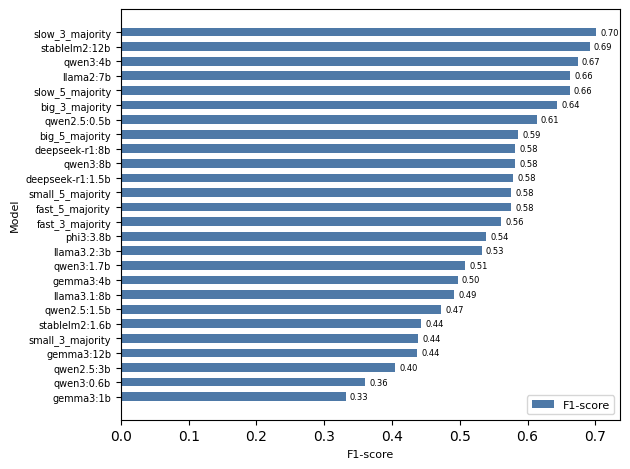

<Figure size 640x480 with 0 Axes>

In [18]:
# F1-Score Comparison
metrics_df = metrics_df.sort_values('f1_score', ascending=True)
models = metrics_df['model'].tolist()
y = np.arange(len(models))
bar_height = 0.6

fig, ax = plt.subplots()
bars_f1 = ax.barh(y, metrics_df['f1_score'], color=colors['f1_score'], height=bar_height, label='F1-score')

ax.bar_label(bars_f1, fmt='%.2f', padding=3, fontsize=6)

ax.set_yticks(y)
ax.set_yticklabels(models, fontsize=7)
ax.set_xlabel('F1-score', fontsize=8)
ax.set_ylabel('Model', fontsize=8)
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()
plt.savefig('../images/f1-score')


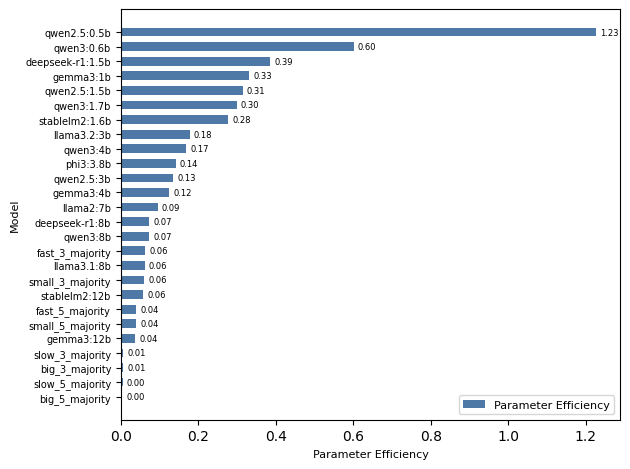

<Figure size 640x480 with 0 Axes>

In [19]:
# Parameter Efficiency Comparison
metrics_df = metrics_df.sort_values('parameter_efficiency', ascending=True)
models = metrics_df['model'].tolist()
y = np.arange(len(models))
bar_height = 0.6

fig, ax = plt.subplots()
bars_f1 = ax.barh(y, metrics_df['parameter_efficiency'], color=colors['f1_score'], height=bar_height, label='Parameter Efficiency')

ax.bar_label(bars_f1, fmt='%.2f', padding=3, fontsize=6)

ax.set_yticks(y)
ax.set_yticklabels(models, fontsize=7)
ax.set_xlabel('Parameter Efficiency', fontsize=8)
ax.set_ylabel('Model', fontsize=8)
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()
plt.savefig('../images/parameters-efficiency')


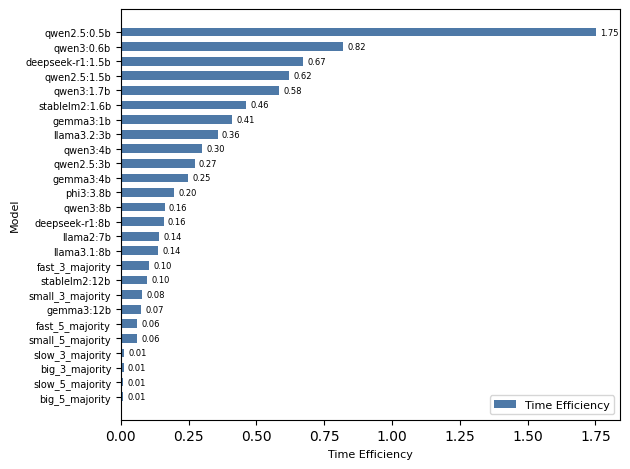

<Figure size 640x480 with 0 Axes>

In [20]:
# Time Efficiency Comparison
metrics_df = metrics_df.sort_values('time_efficiency', ascending=True)
models = metrics_df['model'].tolist()
y = np.arange(len(models))
bar_height = 0.6

fig, ax = plt.subplots()
bars_f1 = ax.barh(y, metrics_df['time_efficiency'], color=colors['f1_score'], height=bar_height, label='Time Efficiency')

ax.bar_label(bars_f1, fmt='%.2f', padding=3, fontsize=6)

ax.set_yticks(y)
ax.set_yticklabels(models, fontsize=7)
ax.set_xlabel('Time Efficiency', fontsize=8)
ax.set_ylabel('Model', fontsize=8)
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()
plt.savefig('../images/time-efficiency')

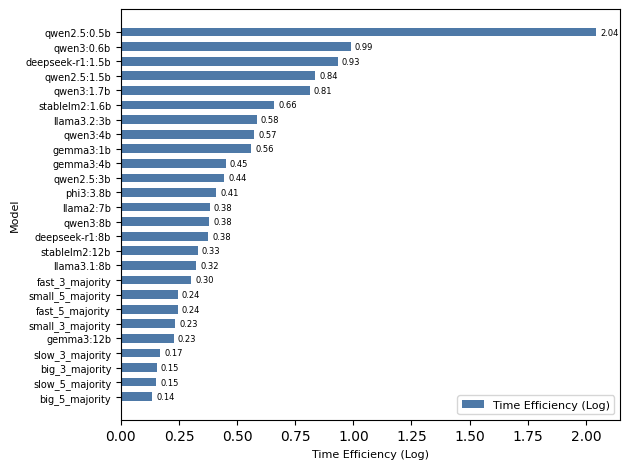

<Figure size 640x480 with 0 Axes>

In [21]:
# Time Efficiency (Log) Comparison
metric = 'efficiency_log'
metrics_df = metrics_df.sort_values(metric, ascending=True)
models = metrics_df['model'].tolist()
y = np.arange(len(models))
bar_height = 0.6

fig, ax = plt.subplots()
bars_f1 = ax.barh(y, metrics_df[metric], color=colors['f1_score'], height=bar_height, label='Time Efficiency (Log)')

ax.bar_label(bars_f1, fmt='%.2f', padding=3, fontsize=6)

ax.set_yticks(y)
ax.set_yticklabels(models, fontsize=7)
ax.set_xlabel('Time Efficiency (Log)', fontsize=8)
ax.set_ylabel('Model', fontsize=8)
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()
plt.savefig('../images/time-efficiency-log')

In [22]:
# f1_by_rating
ratings = sorted(df['rating_real'].unique())

records = []
for model, grp in df.dropna(subset=['model']).groupby('model'):
    for r in ratings:
        y_true = (grp['rating_real'] == r).astype(int)
        y_pred = (grp['rating_llm'] == r).astype(int)
        records.append({
            'model':       model,
            'real_rating': r,
            'f1_score':    f1_score(y_true, y_pred, zero_division=0)
        })

wide_ratings = df.pivot(index='id', columns='model', values='rating_llm')
manual = df[['id','rating_real']].drop_duplicates('id').set_index('id')

for group_name, modelos in groups.items():
    grp_wide = wide_ratings[modelos]
    group_pred = grp_wide.mode(axis=1)[0].fillna(0).astype(int)
    y_true_full = manual['rating_real']
    for r in ratings:
        y_true = (y_true_full == r).astype(int).loc[group_pred.index]
        y_pred = (group_pred == r).astype(int)
        records.append({
            'model':       f'{group_name}_majority',
            'real_rating': r,
            'f1_score':    f1_score(y_true, y_pred, zero_division=0)
        })

f1_by_rating = (
    pd.DataFrame(records)
      .pivot(index='model', columns='real_rating', values='f1_score')
      .fillna(0)
)

display(f1_by_rating.head())


real_rating,1,2,3,4,5
model,,,,,
big_3_majority,0.532374,0.333333,0.395349,0.237762,0.400000
big_5_majority,0.424242,0.463158,0.346667,0.205882,0.400000
deepseek-r1:1.5b,0.285714,0.026316,0.336918,0.342246,0.375000
deepseek-r1:8b,0.454545,0.342342,0.363636,0.205607,0.497462
fast_3_majority,0.421875,0.284091,0.240964,0.024691,0.433735


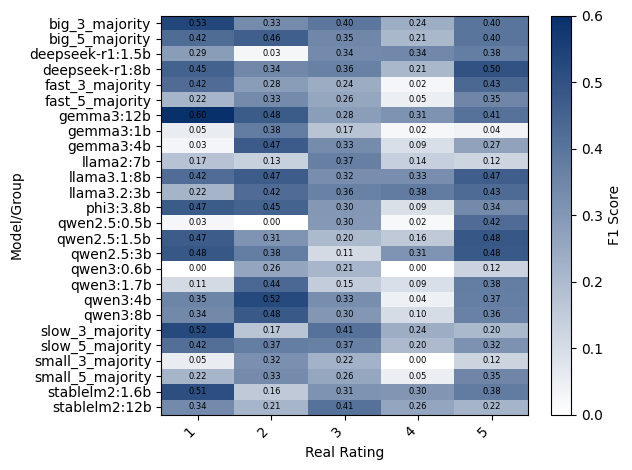

<Figure size 640x480 with 0 Axes>

In [23]:
# f1 by rating heatmap (all)

heatmap_data = f1_by_rating.values
models = f1_by_rating.index.tolist()
ratings = f1_by_rating.columns.tolist()

cmap = LinearSegmentedColormap.from_list(
    'white_to_dark_blue',
    ['#ffffff', '#08306b']
)

vmax = np.nanmax(heatmap_data)

fig, ax = plt.subplots()
im = ax.imshow(
    heatmap_data,
    aspect='auto',
    cmap=cmap,
    vmin=0,
    vmax=vmax
)

ax.set_xticks(np.arange(len(ratings)))
ax.set_xticklabels(ratings)
ax.set_yticks(np.arange(len(models)))
ax.set_yticklabels(models)

plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

for i in range(len(models)):
    for j in range(len(ratings)):
        ax.text(
            j, i,
            f"{heatmap_data[i, j]:.2f}",
            ha='center', va='center',
            fontsize=6,
            color='black'
        )

ax.set_xlabel('Real Rating')
ax.set_ylabel('Model/Group')

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('F1 Score')

plt.tight_layout()
plt.show()
plt.savefig('../images/f1-score-heatmap')


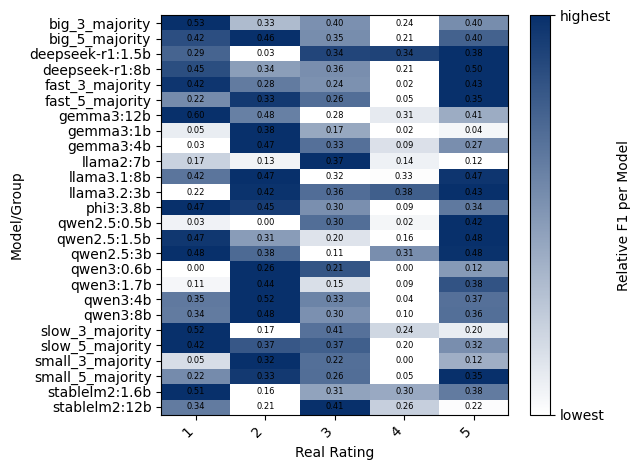

<Figure size 640x480 with 0 Axes>

In [24]:
# f1 by rating heatmap (by model)

data = f1_by_rating.values
models = f1_by_rating.index.tolist()
ratings = f1_by_rating.columns.tolist()

row_min = data.min(axis=1, keepdims=True)
row_max = data.max(axis=1, keepdims=True)
norm_data = (data - row_min) / (row_max - row_min + 1e-9)

cmap = LinearSegmentedColormap.from_list(
    'white_to_dark_blue',
    ['#ffffff', '#08306b']
)

fig, ax = plt.subplots()
im = ax.imshow(norm_data, aspect='auto', cmap=cmap, vmin=0, vmax=1)

ax.set_xticks(np.arange(len(ratings)))
ax.set_xticklabels(ratings)
ax.set_yticks(np.arange(len(models)))
ax.set_yticklabels(models)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

for i in range(len(models)):
    for j in range(len(ratings)):
        ax.text(
            j, i,
            f"{data[i, j]:.2f}",
            ha='center', va='center',
            fontsize=6,
            color='black'
        )

ax.set_xlabel('Real Rating')
ax.set_ylabel('Model/Group')

cbar = fig.colorbar(im, ax=ax, ticks=[0, 1])
cbar.set_ticklabels(['lowest', 'highest'])
cbar.set_label('Relative F1 per Model')

plt.tight_layout()
plt.show()
plt.savefig('../images/f1-score-heatmap-by-model')